# Предсказание стоимости жилья

**Цель исследования** - обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году.

**Задача:**
- Нужно предсказать медианную стоимость дома в жилом массиве
- Сравнить результаты работы модели на двух наборах данных (с категорильными и без категориальных данных) по метрикам RMSE, MAE и R2.

**План исследования**

1. Изучить данные
2. Предподготовка данных
3. Исследовательский анализ
4. Корреляционные анализ
5. Кодирование данных
6. Обучение моделей
7. Анализ результатов
8. Общий вывод

Согласно документации к данным:

Таблица `housing` содержит информацию о жилых массивах в Калифорнии

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

## Изучение данных

### Импорт библиотек

In [3]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml import Pipeline

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics

import phik
from phik.report import plot_correlation_matrix

### Константы

In [4]:
RANDOM_SEED = 2022

### Загрузка данных

Инициализируем локальную Spark-сессию.

In [5]:
spark = SparkSession.builder.master('local').appName('Califorina Housing').getOrCreate()

Прочитаем файл `housing.csv` и сохраним его в переменной `housing`

In [6]:
pth = '/datasets/housing.csv'

In [7]:
if os.path.exists(pth):
    housing = spark.read.option('header', 'true').csv(pth, inferSchema=True)
else:
    print('Ошибка')

Выведем первые 5 строк

In [8]:
housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Теперь выведим типы данных колонок датасета и посмотрим на описательную статистику

In [9]:
print(pd.DataFrame(housing.dtypes, columns=['column', 'type']).head(10))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


In [10]:
housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Всего в таблице 10 столбцов. Все столбцы, кроме `ocean_proximity` имеют тип данных `doble`, он имеет тип данных `string`.  В датасете примерно 21 тысяча строк. Максимальная медианная стоимость дома равна полумиллиону долларов. 

### Вывод

Каждая сторка таблиц содержит информацию о жилых массивах в Калифорнии. Стоит сделать следующие шаги:

1. Проверить на наличие пропусков в данных и если есть заполнить понеобходимости.
2. Проверить явные и неявные дубликаты и если есть повозможности избавиться от них.

## Предобработка данных
### Работа с пропусками

Проверим есть ли пропущенные значения в датафрейме. Добавим проверку колонки в переменную col_fl. Приведем значения к типу `float` методом `cast()` и проверим на наличие значений `[None, np.nan, NULL]`.

In [11]:
columns = housing.columns

for column in columns:
    ch_col = (F.col(column).isNull() | F.isnan(F.col(column)))
    print(column, housing.filter(ch_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


 Заполним пропуски медианным значением по cтолбцу `total_bedrooms`

In [12]:
housing_sp = housing.na.fill(int(housing.approxQuantile('total_bedrooms', [0.5], 0)[0]))

In [13]:
#housing_sp = housing.na.fill(housing.select(F.mean('total_bedrooms')).collect()[0][0])

Проверим заполнились ли пропуски

In [14]:
columns = housing_sp.columns

for column in columns:
    ch_col = (F.col(column).isNull() | F.isnan(F.col(column)))
    print(column, housing_sp.filter(ch_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Пропуски заполнены

### Работа с явными дубликатами

Если дубликаты присутсвуют, то мы удалим их. Выведем количество значений

In [15]:
housing_sp.count()

20640

Удалим дубликаты, если они есть

In [16]:
housing_sp.dropDuplicates().count()

20640

Явных дубликатов  не обнаружено

### Работа с неявными дубликатми

Неявные дубликаты могут быть только в колонке `ocean_proximity`, поэтому выберем ее и выведем уникальные значения, чтобы посмотреть есть ли неявные дубликаты.

In [17]:
ocean_dist = housing_sp.select('ocean_proximity').distinct()
print(ocean_dist.collect())

[Row(ocean_proximity='ISLAND'), Row(ocean_proximity='NEAR OCEAN'), Row(ocean_proximity='NEAR BAY'), Row(ocean_proximity='<1H OCEAN'), Row(ocean_proximity='INLAND')]


Неявных дубликатов также не обнаружено

### Вывод

На данном этапе были сделаны следующие действия:

1. Сделали проверку на пропуски. Пропуски были в одном столбце `total_bedrooms`, заполнили их средним значением по столбцу `total_bedrooms`.
2. Сделали проверку на явные дубликаты - **не обнаружены**.
3. Сделали проверку на неявные дубликаты - **не обнаружены**.

## Исследовательский анализ

Исследуем данные в датафрейме. Выясним процентное соотношение `ocean_proximity`, построив для этого круговую диаграмму. А также изучим колличественные переменные, построив гистограммы и боксплоты.

Начнем с анализа `ocean_proximity` и построим круговую диаграмму, но перед этим сделаем группировку по этому столбцу и посчитаем количество каждой категории.

In [18]:
df_ocean_prox = housing_sp.groupBy('ocean_proximity').agg(F.count('total_rooms')).toPandas()

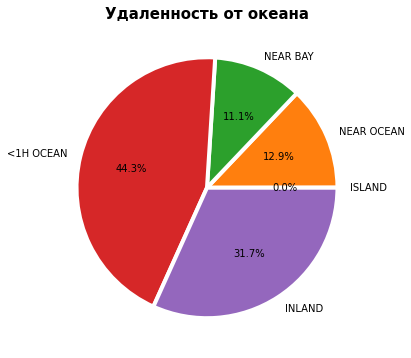

In [19]:
plt.figure(figsize=(10, 6))
plt.pie(df_ocean_prox['count(total_rooms)'], labels=df_ocean_prox['ocean_proximity'], 
        autopct='%.1f%%', wedgeprops={'linewidth':4, 'edgecolor':'white'})
plt.title('Удаленность от океана', fontsize=15, fontweight='bold');

В результате получаем следующиее соотношение категорий:

- `<1H OCEAN` - 44.3%
- `INLAND` - 31.7%
- `NEAR OCEAN` - 12.9%
- `NEAR BAY` - 11.1%
- `ISLAND` - 0%

Теперь изучим количественные перменные и сначала построим диаграмму размаха.

In [20]:
sampled_housing = housing.sample(True, 0.2, seed=RANDOM_SEED)

In [21]:
sampled_housing.count()

4113

In [22]:
df = sampled_housing.toPandas() # Создаем отдельный датафрейм

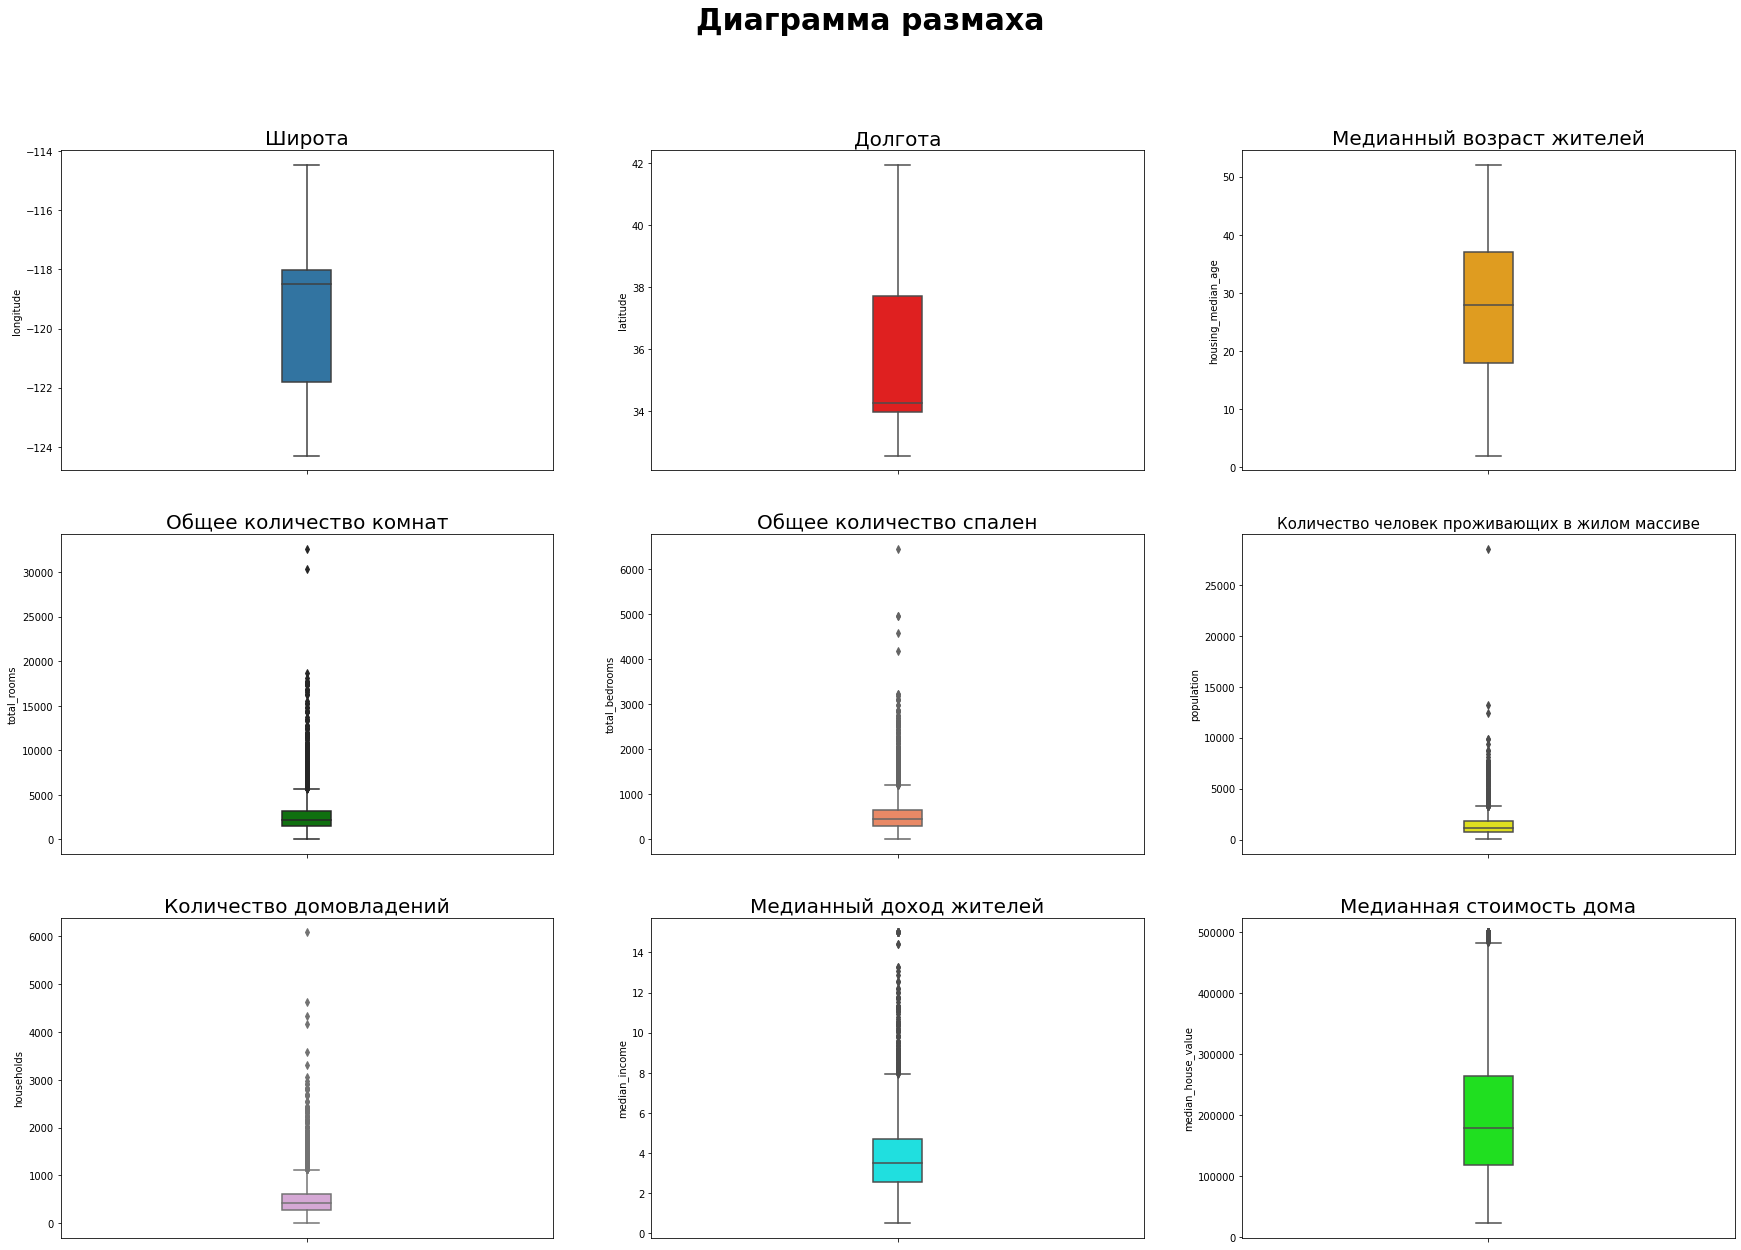

In [23]:
plt.figure(figsize=(30, 20))

plt.suptitle('Диаграмма размаха', fontsize=30, fontweight='bold')

plt.subplot(3, 3, 1)
sns.boxplot(y=df['longitude'], width=.1)
plt.title('Широта', fontsize=20)

plt.subplot(3, 3, 2)
sns.boxplot(y=df['latitude'], width=.1, color='red')
plt.title('Долгота', fontsize=20)

plt.subplot(3, 3, 3)
sns.boxplot(y=df['housing_median_age'], width=.1, color='orange')
plt.title('Медианный возраст жителей', fontsize=20)

plt.subplot(3, 3, 4)
sns.boxplot(y=df['total_rooms'], width=.1, color='green')
plt.title('Общее количество комнат', fontsize=20)

plt.subplot(3, 3, 5)
sns.boxplot(y=df['total_bedrooms'], width=.1, color='coral')
plt.title('Общее количество спален', fontsize=20)

plt.subplot(3, 3, 6)
sns.boxplot(y=df['population'], width=.1, color='yellow')
plt.title('Количество человек проживающих в жилом массиве', fontsize=15)

plt.subplot(3, 3, 7)
sns.boxplot(y=df['households'], width=.1, color='plum')
plt.title('Количество домовладений', fontsize=20)

plt.subplot(3, 3, 8)
sns.boxplot(y=df['median_income'], width=.1, color='cyan')
plt.title('Медианный доход жителей', fontsize=20)

plt.subplot(3, 3, 9)
sns.boxplot(y=df['median_house_value'], width=.1, color='lime')
plt.title('Медианная стоимость дома', fontsize=20);

Из графиков видно, что в некоторых столбцах есть выбросы, но сами эти значения не будут аномальными, так как на диаграмме "общее количество комнат", так как это количество комнант в жилом массиве то такие отклоненние от медианы вполне естественно, так как массивы отличаются между собой домами, которые в них расположенны. Аналогично и для количества спален, так как домов в некоторых массивах больше и сами дома больше то и количество спален могут выбиваться от обычного количества, а следовательно и количество людей проживающих в них тоже будуте другим. По диаграмме "медианный доход жителей" тоже вполне естественно, так как в некоторых массивах просто живут люди с доходом выше среднего, что и послужило такими "выбросами". 

Теперь построим гистограммы по количественным переменным.

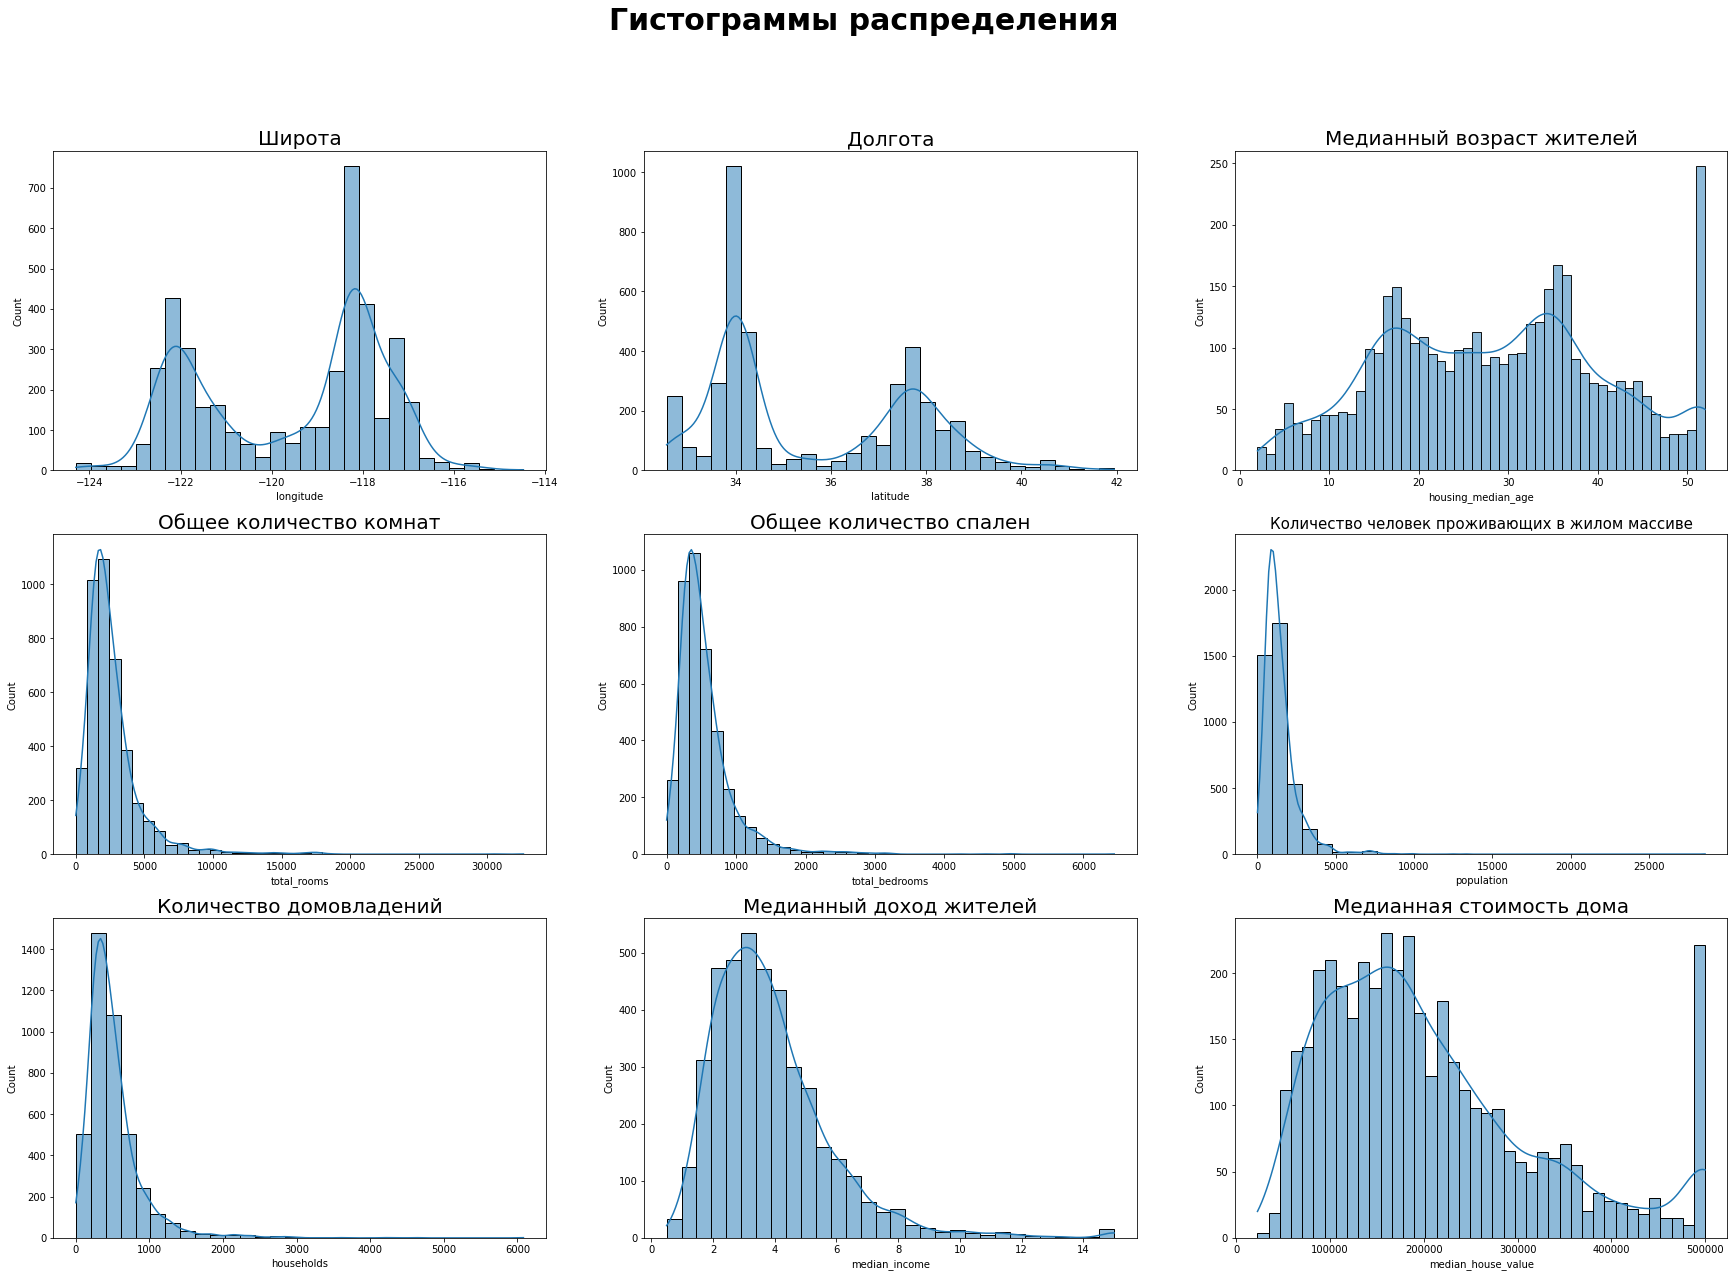

In [24]:
plt.figure(figsize=(30, 20))

plt.suptitle('Гистограммы распределения', fontsize=30, fontweight='bold')

plt.subplot(3, 3, 1)
sns.histplot(df['longitude'], kde=True, bins=30)
plt.title('Широта', fontsize=20)

plt.subplot(3, 3, 2)
sns.histplot(df['latitude'], kde=True, bins=30)
plt.title('Долгота', fontsize=20)

plt.subplot(3, 3, 3)
sns.histplot(df['housing_median_age'], kde=True, bins=50)
plt.title('Медианный возраст жителей', fontsize=20)

plt.subplot(3, 3, 4)
sns.histplot(df['total_rooms'], kde=True, bins=40)
plt.title('Общее количество комнат', fontsize=20)

plt.subplot(3, 3, 5)
sns.histplot(df['total_bedrooms'], kde=True, bins=40)
plt.title('Общее количество спален', fontsize=20)

plt.subplot(3, 3, 6)
sns.histplot(df['population'], kde=True, bins=30)
plt.title('Количество человек проживающих в жилом массиве', fontsize=15)

plt.subplot(3, 3, 7)
sns.histplot(df['households'], kde=True, bins=30)
plt.title('Количество домовладений', fontsize=20)

plt.subplot(3, 3, 8)
sns.histplot(df['median_income'], kde=True, bins=30)
plt.title('Медианный доход жителей', fontsize=20)

plt.subplot(3, 3, 9)
sns.histplot(df['median_house_value'], kde=True, bins=40)
plt.title('Медианная стоимость дома', fontsize=20);

Многие количественные признаки распределены ненормально. `longitude`, `latitude`, `housing_median_age` и `median_house_value` - имеют мультимодальное распределение. Также можно отметить очень заметный пик после 50 в возрасте и пик возле 500000 в стоимсоти дома.
Остальные признаки имеют уномодальное распределение.

### Вывод

По результатам исследователького анализа можно сделать следующие выводы:

1. По удалености от океана категории расположилось следующим образом:
    - `<1H OCEAN` - 44.3%
    - `INLAND` - 31.7%
    - `NEAR OCEAN` - 12.9%
    - `NEAR BAY` - 11.1%
    - `ISLAND` - 0%
2. Из графиков видно, что в некоторых столбцах есть выбросы, но сами эти значения не будут аномальными, так как на диаграмме "общее количество комнат", так как это количество комнант в жилом массиве то такие отклоненние от медианы вполне естественно, так как массивы отличаются между собой домами, которые в них расположенны. Аналогично и для количества спален, так как домов в некоторых массивах больше и сами дома больше то и количество спален могут выбиваться от обычного количества, а следовательно и количество людей проживающих в них тоже будуте другим. По диаграмме "медианный доход жителей" тоже вполне естественно, так как в некоторых массивах просто живут люди с доходом выше среднего, что и послужило такими "выбросами".
3. Многие количественные признаки распределены ненормально. `longitude`, `latitude`, `housing_median_age` и `median_house_value` - имеют мультимодальное распределение. Также можно отметить очень заметный пик после 50 в возрасте и пик возле 500000 в стоимсоти дома. Остальные признаки имеют уномодальное смещеное распределение.

## Корреляционные анализ

Необходимо провести корреляционный анализ, для того, чтобы выяснить нет ли мультиколлинеарности между признаками. Так как данные у нас распределенны ненормально, то воспользуемся специальной библиотекой `phik` она рассчитывает коэффициент корреляции $\phi_k$, который находит может находить взаимосвязи нетолько между числовыми, но и категориальными признаками. 

In [25]:
# Рассчитываем коэффициент корреляции
phik_matrix = df.phik_matrix(interval_cols=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
           'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'])

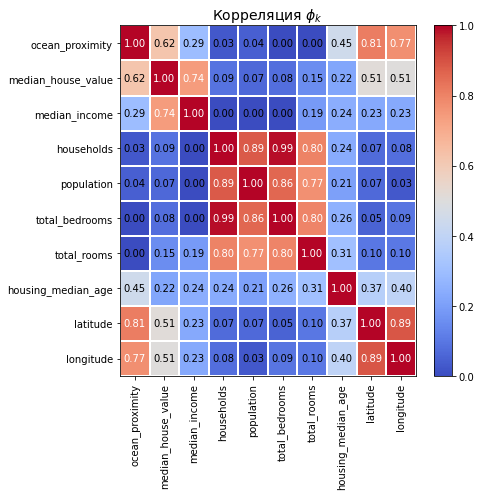

In [26]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                       figsize=(7,7))

plt.tight_layout()

Наш целевой признак `median_house_value` не имеет мультиколлинеарности, но есть сильная взаимосвязь с `median_income` - 0.74 и `ocean_proximity` - 0.62. Также есть взаимосвязь с `longitude` и `latitude` - 0.51 и 0.51.

Между входными признаками заметна мультиколлинеарность, а именно между `households` и `total_bedrooms` - 0.99

Между остальными признаками есть только сильная взаимосвязь между `longitude` и `latitude` - 0.89

Необходимо избавиться от мультиколлинеарности и для этого удалим столбец `households`. И еще раз построим матрицу корреляции.

*также удалим столбец `total_rooms`, так как после удаления `households`, столбец `total_rooms` стал иметь мультиколлинеарность с большм количеством признаков.*

In [27]:
# Рассчитываем коэффициент корреляции
phik_matrix = (
    df.drop(columns=['households', 'total_rooms'], axis=1)
    .phik_matrix(interval_cols=['longitude', 'latitude', 'housing_median_age', 
                                'total_bedrooms', 'population', 'median_income', 'median_house_value']))

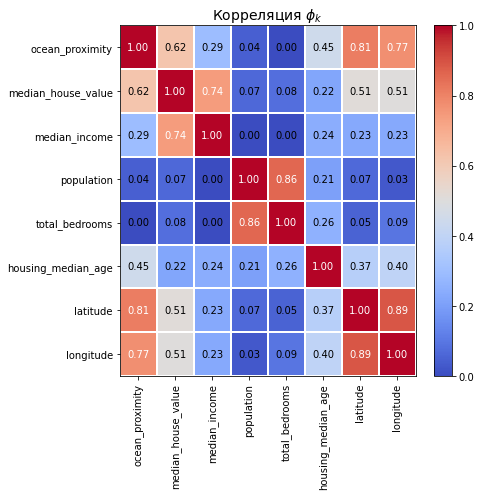

In [28]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                       vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                       figsize=(7,7))

plt.tight_layout()

В результате мы избавились от мультиколлинеарности

## Кодирование данных

Кодирование и стандартизацию будем делать в `pipeline`. Категориальные значение преобразуем техникой `Onehotencoding`, а числовые отшкалируем техникой `StandardScaler`.

В начале разделим колонки на два типа: числовые и категориальные данные. Также выделим отдельно целевой признак.

In [29]:
cat_col = ['ocean_proximity']
num_col = ['longitude', 'latitude', 'housing_median_age', 
           'total_bedrooms', 'population', 'median_income']
target = 'median_house_value'

Делаем кодирование в `pipeline`

In [30]:
stages = []

In [31]:
indexer = StringIndexer(inputCols=cat_col, outputCols=[cat_col[0]+'_idx'], handleInvalid = 'keep')

encoder = OneHotEncoder(inputCols=[cat_col[0]+'_idx'], outputCols=[cat_col[0]+'_ohe'])

stages += [indexer, encoder]

In [32]:
cat_assembler = VectorAssembler(inputCols=[cat_col[0]+'_ohe'], outputCol='cat_features')
stages += [cat_assembler]

In [33]:
num_assembler = VectorAssembler(inputCols=num_col, outputCol='num_features')

stages += [num_assembler]

scaler = StandardScaler(inputCol='num_features', outputCol='num_features_scaled')

stages += [scaler]

In [34]:
all_features = ['cat_features', 'num_features_scaled']

total_assembler = VectorAssembler(inputCols=all_features, outputCol='features')

stages += [total_assembler]

## Обучение моделей

Разделим на тренировочную и тестовую выборку

In [35]:
train_df, test_df = housing_sp.randomSplit([.8,.2], seed=RANDOM_SEED)

Приступим к обучению модели. Наш целевой признак - `median_house_value`, то есть медианная стоимость дома в жилом массиве. То есть перед нами задача регрессии. Необходимо использовать `LinearRegression`. Будут обучаться две модели:
1. Со всеми признаками (числовые и категориальные)
2. Только числовые признаки.

Результат работ модели будет сравнивать по метрикам `RMSE`, `MAE` и `R2`.

Начнем с первой модели, которая включается в себя все признаки.

In [36]:
lr = LinearRegression(labelCol=target, featuresCol='features', regParam=0.3, elasticNetParam=0, 
                      predictionCol='prediction_num_cat')

stages += [lr]

pipeline = Pipeline(stages=stages)

In [37]:
model = pipeline.fit(train_df)

24/05/25 09:44:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/05/25 09:44:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/05/25 09:44:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/05/25 09:44:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [38]:
predict = model.transform(test_df)
predict_labes = predict.select(['prediction_num_cat', 'median_house_value'])

Приступим к обучению второй модели (только числовые признаки) и сделаем прогноз.

In [39]:
lr_num = LinearRegression(labelCol=target, regParam=0.3, elasticNetParam=0,
                          featuresCol='num_features_scaled')

stages += [lr_num]

pipeline_num = Pipeline(stages=stages)

In [40]:
model_num = pipeline_num.fit(train_df)

In [41]:
predict_num = model_num.transform(test_df)
predict_labes_num = predict_num.select(['prediction', 'median_house_value'])

## Анализ результатов

Оценим результат работы моделей на метриках. Начнем с первой модели (со всеми признаками)

In [42]:
result = predict_labes.collect()
result_lst = [(float(i[0]), float(i[1])) for i in result]
predict_labes = spark.sparkContext.parallelize(result_lst)

In [43]:
metrics = RegressionMetrics(predict_labes)

print(f'RMSE: {metrics.rootMeanSquaredError:.2f}')
print(f'MAE: {metrics.meanAbsoluteError:.2f}')
print(f'r2: {metrics.r2:.2f}')

RMSE: 68880.58
MAE: 50272.94
r2: 0.65


По результатам первой модели. Получаем, что в `65%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака.

`RMSE` показывает, что в среднем на `68880.58` предсказания отличаются от истиного значения

`MAE` показывает, что в среднем на `50272.94` предсказания отличаются от истиного значения

Посмотрим на результат работы второй модели

In [44]:
result_num = predict_labes_num.collect()
result_lst_num = [(float(i[0]), float(i[1])) for i in result_num]
predict_labes_num = spark.sparkContext.parallelize(result_lst_num)

In [45]:
metrics_num = RegressionMetrics(predict_labes_num)

print(f'RMSE: {metrics_num.rootMeanSquaredError:.2f}')
print(f'MAE: {metrics_num.meanAbsoluteError:.2f}')
print(f'r2: {metrics_num.r2:.2f}')

RMSE: 69696.64
MAE: 51356.84
r2: 0.64


По результатам второй модели. Получаем, что в `64%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака.

`RMSE` показывает, что в среднем на `69696.64` предсказания отличаются от истиного значения

`MAE` показывает, что в среднем на `51356.84` предсказания отличаются от истиного значения

В результате можно сказать, что первая модель лучше второй, так как она по всем метрикам лучше второй, хоть и не намного.

In [46]:
spark.stop()

## Вывод

Данные были получены из файла:

- `/datasets/housing.csv`

Сначала был сделан обзор данных. Само исследование проходило в 6 этапов:

1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ
4. Кодирование данных
5. Обучение моделей
6. Анализ результатов
7. Общий вывод

**1. Изученние данных**

Вначале была инициализированна локальная spark-сессия.

После изучения всех данных, выяснили. Всего в таблице 10 столбцов. Все столбцы, кроме `ocean_proximity` имеют тип данных `doble`, он имеет тип данных `string`.  В датасете примерно 21 тысяча строк. Максимальная медианная стоимость дома равна полумиллиону долларов. 

**2. Предобработка данных**

Сделали проверку на пропуски. Пропуски были в одном столбце `total_bedrooms`, заполнили их медианными значениями по каждой категории `ocean_proximity`.

Сделали проверку на явные дубликаты - **не обнаружены**.

Сделали проверку на неявные дубликаты - **не обнаружены**.

**3. Исследовательский анализ**

По результатам исследователького анализа сделали следующие выводы:

1. По удалености от океана категории расположилось следующим образом:
    - `<1H OCEAN` - 44.3%
    - `INLAND` - 31.7%
    - `NEAR OCEAN` - 12.9%
    - `NEAR BAY` - 11.1%
    - `ISLAND` - 0%
2. Из графиков видно, что в некоторых столбцах есть выбросы, но сами эти значения не будут аномальными, так как на диаграмме "общее количество комнат", так как это количество комнант в жилом массиве то такие отклоненние от медианы вполне естественно, так как массивы отличаются между собой домами, которые в них расположенны. Аналогично и для количества спален, так как домов в некоторых массивах больше и сами дома больше то и количество спален могут выбиваться от обычного количества, а следовательно и количество людей проживающих в них тоже будуте другим. По диаграмме "медианный доход жителей" тоже вполне естественно, так как в некоторых массивах просто живут люди с доходом выше среднего, что и послужило такими "выбросами".
3. Многие количественные признаки распределены ненормально. `longitude`, `latitude`, `housing_median_age` и `median_house_value` - имеют мультимодальное распределение. Также можно отметить очень заметный пик после 50 в возрасте и пик возле 500000 в стоимсоти дома. Остальные признаки имеют уномодальное смещеное распределение.

**4. Корреляционный анализ**

Так как мы выяснили, что данные у нас распределенны ненормально для анализа взаимосвязи воспользовались модулем `phik`. В результате получили, что наш целевой признак `median_house_value` не имеет мультиколлинеарности, но есть сильная взаимосвязь с `median_income` - 0.74 и `ocean_proximity` - 0.62. Также есть взаимосвязь с `longitude` и `latitude` - 0.51 и 0.51.

Также была заметна мультиколлинеарность между `households` и `total_bedrooms` - 0.99

Избавились от нее при помощи удаления столбца `households`. Также в дальнейшем удалили столбец `total_rooms`, так как после удаления столбца `households`, у этого столбца появилась мультиколлинеарность с несколькими признаками.


**5. Кодирование данных**

Перед обучение необходимо было закодировать признаки. Для этого разделили признаки на категориальные и числовые, а также выделили целевой признак. Кодирование происходило в `pipeline`.

Единственный категориальный признак `ocean_proximity` был закодирован с помощью `Onehotencoding`

Для числовых признаков сделали шаклирование с помощью `StandardSacler`

**6. Обучение модели**

Наш целевой признак - `median_house_value`, то есть медианная стоимость дома в жилом массиве. И в результате получаем задачу регрессии. Необходимо использовать `LinearRegression`. Обучали две модели:
1. Со всеми признаками (числовые и категориальные)
2. Только числовые признаки.

Результат работ моделей сравнивали по метрикам `RMSE`, `MAE` и `R2`.

**7. Анализ результатов**

По результатам первой модели. Получаем, что в `65%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака.

`RMSE` показывает, что в среднем на `68880.58` предсказания отличаются от истиного значения

`MAE` показывает, что в среднем на `50272.94` предсказания отличаются от истиного значения

По результатам второй модели. Получаем, что в `64%` случаев предсказания модели ближе к истине, чем среднее значение целевого признака.

`RMSE` показывает, что в среднем на `69696.64` предсказания отличаются от истиного значения

`MAE` показывает, что в среднем на `51356.84` предсказания отличаются от истиного значения

**Вывод**

По результатам исследования получили две модели. Первая из моделей, которая включает все признаки получилась лучше, хоть результат не намного лучше.